### Etivity 6
The main goal of this etivity is to create a portfolio of assets(stocks and bonds) for a couple with the below information: <br>
- 55 year old medical doctor living in Limerick with her husband who is a lecturer in the local university
- two grown children who are both graduated and working in Dublin
- have paid their mortgage fully
- house: €375,000
- income: €215,000/annum gross of taxes
- saving: €165,000 in cash
- plan to 
	- retire in 10 years 
	- downsizing their residence to an apartment in Limerick 
	- buy an apartment in Barcelona as a Winter retreat
	- have an income from a portfolio to augment their pensions when they retire.

As the above information is not enough for a detailed life/retirement planning. <br>
My approach to this problem to use above mainly as general information without digging into the details. <br>
#### Core Assumptions
- Client should be able to purchase two properties by selling their current house
- Client have enough money from their pension to survive after retirement
- Investment goal is to increase the quality of living
- Low to Medium risk tolerance because investment income is not safeguard survival
- Time Line(Simplified):
    - Irish Life Expectancy: Male(80) | Female(83)
    - Years to Retirement: 10 years
    - Years after Retirement: 15 years

#### Investment Cashflows
Client will invest €82,500 (half of cash saving) at age 55 and €30,000ish(roughly 17% of income[2% inflation, 20% tax]) every year until retirement.<br>
After retirement, client will withdraw 5% of the investment as an annuity every year until age 85.

#### Breakdown - Steps
1. Portfolio Allocation (Now)
    - Portfolio Optimization
    - Portfolio Expected Return
    - Portfolio Standard Deviation
    - Portfolio Analysis
    - FX Rates
2. Evaluate Investment (Upon Retirement)
    - Net Present Value
    - Future Value
    - Tax(20%)
    - Inflation(2%)
3. Evaluate Investment (After Retirement)
    - Present Value of Annuity



<br>
- Market Links
- Globalization
- Stock Beta


In [1]:
# IMPORTS
import cvxpy as cvx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy_financial as nf


#### Helper Functions

In [2]:
def portfolio_std(weight_map, logged_chgn_df):
    """
        Calculates the standard deviation of the entire portfolio for any number stocks in a portfolio.

        Parameters
        ----------
        weight_map: a dictionary that maps a stock symbol to it's weight in the portfolio.
        logged_chgn_df: dataframe that contains the logged daily change for each stock.
        Note: the keys(stock symbol) in the weight_map must be available in the logged_chgn_df in order to pull the stock data for calculation

        Returns
        -------
        Standard deviation of the whole portfolio.
    """
    all_weight = sum([x for x in weight_map.values()])
    if round(all_weight, 2) != 1:
        raise Exception('Weights does not sum to 1: ', all_weight)

    # aw**2 * a_std**2 + bw**2 * b_std**2 + cw**2 * c_std**2 + 2*aw*bw*a_std*b_std*ab + 2*aw*cw*a_std*c_std*ac + 2*bw*cw*b_std*c_std*bc
    # portfolio standard deviation can be broken into two parts
    # part 1: the normal components - weight^2 * std^2 for each asset
    # e.g. a_weight^2 * a_std^2
    normal_components = []
    for code, weight in weight_map.items():
        data = logged_chgn_df[code]
        std = data.std()
        normal_components.append(weight**2 * std**2)

    # part 2: correlation components - 2 * a_weight * b_weight * a_std * b_std * corr_a_b for each pair of assets
    # e.g. 2 * a_weight * b_weight * a_std * b_std * corr_a_b
    # note: correlation is between 2 assets, below logic will only calc correlation for a_c and not c_a
    corr_components = {}
    for key1 in weight_map:
        for key2 in weight_map:
            keys = [key1, key2]
            keys.sort()

            generated_key = f'{keys[0]}_{keys[1]}'
            if keys[0] != keys[1] and corr_components.get(generated_key) == None:
                w1, data1 = weight_map[keys[0]], logged_chgn_df[keys[0]]
                w2, data2 = weight_map[keys[1]], logged_chgn_df[keys[1]]
                std1 = data1.std()
                std2 = data2.std()
                corr = data1.corr(data2)
                corr_components[generated_key] = 2*w1*w2*std1*std2*corr

    # finally, we sum all the components together
    var = 0
    for nor_cmp in normal_components:
        var = var + nor_cmp

    for corr_cmp in corr_components.values():
        var = var + corr_cmp
    std = np.sqrt(var)
    return std


def optimize_three_asset_portfolio(varA, varB, varC, rAB, rAC, rBC):
    """
        Function that takes in the variance of Stock A, B and C 
        together with the correlation between each pair of stocks as arguments and returns 
        the vector of optimal weights.

        Parameters
        ----------
        varA : float - The variance of Stock A.
        varB : float - The variance of Stock B.    
        varC : float - The variance of Stock C.
        rAB  : float - The correlation between Stocks A and B.
        rAC  : float - The correlation between Stocks A and C.
        rBC  : float - The correlation between Stocks B and C.

        Returns
        -------
        x : np.ndarray
            A 3-elements numpy ndarray containing the weights on Stocks A, B and C,
            [x_A, x_B, x_C], that minimize the portfolio variance.
    """

    covAB = np.sqrt(varA)*np.sqrt(varB)*rAB
    covAC = np.sqrt(varA)*np.sqrt(varC)*rAC
    covBC = np.sqrt(varB)*np.sqrt(varC)*rBC
    x = cvx.Variable(3)
    P = np.array(
        [[varA, covAB, covAC], [covAB, varB, covBC], [covAC, covBC, varC]])
    objective = cvx.Minimize(cvx.quad_form(x, P))
    constraints = [sum(x) == 1]
    problem = cvx.Problem(objective, constraints)
    min_value = problem.solve()
    xA, xB, xC = x.value

    return xA, xB, xC


def optimize_portfolio_allocation(log_change_df, three_assets=('a', 'b', 'c')):
    """
        This is a wrapper function that takes logged daily changes in adj prices dataframe and three assets(string).
        It calculates the variances and correlations needed for 'optimize_three_asset_portfolio' and return the result from that function.

        Parameters
        ----------
        log_change_df: the dataframe that contains the logged daily changes in adj prices for each asset
        three_assets: a tuple that contains three asset codes. The raw data for these three asset codes must be in log_change_df

        Returns
        -------
        return value from optimize_three_asset_portfolio
    """
    asset_a, asset_b, asset_c = three_assets
    var_a = log_change_df[asset_a].var()
    var_b = log_change_df[asset_b].var()
    var_c = log_change_df[asset_c].var()
    corr_ab = log_change_df[asset_a].corr(log_change_df[asset_b])
    corr_ac = log_change_df[asset_a].corr(log_change_df[asset_c])
    corr_bc = log_change_df[asset_b].corr(log_change_df[asset_c])
    return optimize_three_asset_portfolio(var_a, var_b, var_c, corr_ab, corr_ac, corr_bc)


def update_USD_price_into_EUR_price(invest_df, fx_df):
    for col_name in invest_df:
      if 'USD' in col_name:
        new_col_name = col_name[0:-3] + 'EUR'
        invest_df[new_col_name] = invest_df[col_name] / fx_df['EURUSD']
        invest_df.drop(col_name, axis=1, inplace=True)


def calc_future_value(ror=0, cash_flows=[]):
    """
        calculates the future value of all cash flows
        arguments:
            ror: rate of return
            cash_flows: series of cash flows, each element(number) in the list is cash flow for that period
                        e.g. [0, 100] => first period receives 0 and second period receives 100
                        note: first value is the cashflow now
        return:
            sum of all cash flow future values
    """
    fvcfs = []
    total_periods = len(cash_flows) - 1
    for period_num, val in enumerate(cash_flows):
        # calc the future value of each cash flow
        fvcf = val / (1 + ror)**(period_num - total_periods)
        # append individual cash flow into all cash flows
        fvcfs.append(fvcf)
    return round(sum(fvcfs), 2)


def calc_npv(ror=0, cash_flows=[]):
    """
        npv: calculates the present value of all cashflows
        arguments:
            ror: rate of return
            cash_flows: series of cash flows, each element(number) in the list is cash flow for that period
                        e.g. 
                            [0, 100] => first period receives 0 and second period receives 100
                            [-100, 0] => first period invest 100 and second period receives 0
                        note: first value is the cashflow now
        return:
            sum of all cash flow present values: PV(Benefits) - PV(Costs)
    """
    pvcfs = []
    for period_num, val in enumerate(cash_flows):
        # calc the present value of each cash flow
        pvcf = val / (1 + ror)**period_num
        # append individual cash flow into all cash flows
        pvcfs.append(pvcf)
    npv = round(sum(pvcfs), 2)
    return npv

def generate_annuity(initial_portfolio_value, inv_return, period):
    """
        npv: generates the list of annuities generated from the portfolio and also the portfolio value each period
             for each period, portfolio value with grow at inv_return rate
             annuity (5% of portfolio value) for that period will be taken out of the portfolio
             the remaining (95% of portfolio value) will be saved as portfolio value
        arguments:
            initial_portfolio_value: initial portfolio value
            inv_return: this is the portfolio rate of return - portfolio will continue to grow at this rate
            period: the number periods to generate the portfolio values and annuities
        return:
            portfolio_values: series of portfolio values | each value represents the value of the portfolio for that period
            annuities: series of annuities | each value represents the value of annuity that is taken out of the portfolio value
    """
    portfolio_values = []
    annuities = []
    for _ in range(period):
      portfolio_value = initial_portfolio_value if len(portfolio_values) == 0 else portfolio_values[-1]
      portfolio_value_aft_growth = portfolio_value * (1 + inv_return)
      portfolio_value_aft_withdrawal = round(portfolio_value_aft_growth * 0.95, 0)
      withdrawal = round(portfolio_value_aft_growth * 0.05, 0)
      annuities.append(withdrawal)
      portfolio_values.append(portfolio_value_aft_withdrawal)
    return annuities, portfolio_values


#### Step 1 : Portfolio Allocation - Get Average % Return for Estimation

Asset Selection:
- Tested many instruments and select based on simple fundamental/qualitative analysis
- Bond is ETF because unable to find historical price for bond
- One stock(IBE.MC) should be ETF but unable to find ETF priced in EUR
- prices are convert to EUR because clients lives in Europe and transact mostly in EUR

In [3]:
# https://etfdb.com/etfs/
# https://www.marketwatch.com/market-data
# https://finance.yahoo.com/

fx_df = pd.read_csv('./FX Rates.csv', index_col=0)
invest_df = pd.read_csv('./All Prices.csv', index_col=0)
update_USD_price_into_EUR_price(invest_df, fx_df)

col_names = invest_df.columns
a1, a2, a3 = col_names[0], col_names[1], col_names[2]

a1_price_change = (invest_df[a1].iloc[-1] - invest_df[a1].iloc[0]) / invest_df[a1].iloc[0] / 10
a2_price_change = (invest_df[a2].iloc[-1] - invest_df[a2].iloc[0]) / invest_df[a2].iloc[0] / 10
a3_price_change = (invest_df[a3].iloc[-1] - invest_df[a3].iloc[0]) / invest_df[a3].iloc[0] / 10

return_map = {a1: round(a1_price_change, 6), a2: round(a2_price_change, 6), a3: round(a3_price_change, 6)}
print(f'Get the average percentage price change for the past few years {return_map}')


Get the average percentage price change for the past few years {'IBE.MC | EUR': 0.210864, 'EUO ETF | EUR': 0.063515, 'TLT ETF | EUR': 0.096689}


#### Step 1 : Portfolio Allocation - Plot Normalized Graph
Plot the normalized prices to observe general trend and correlation between assets

<AxesSubplot:title={'center':'Close Prices'}>

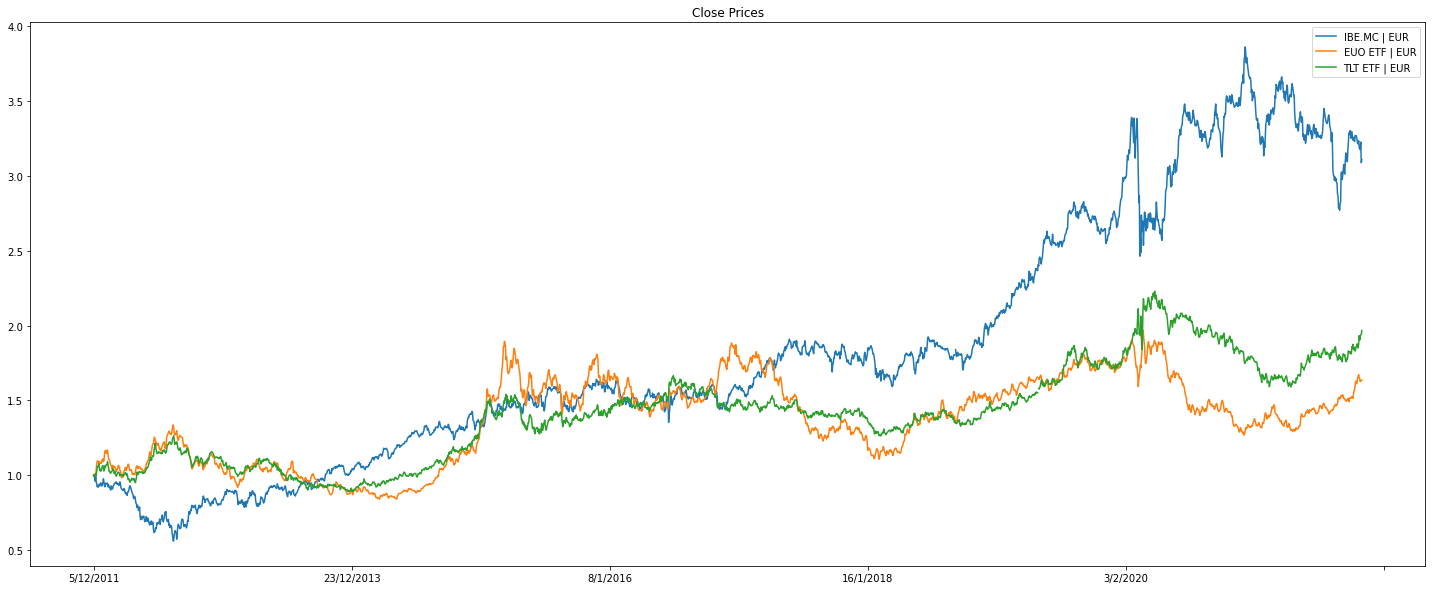

In [4]:
norm_df = invest_df/invest_df.iloc[0, :]
norm_df.plot(title="Close Prices", figsize=(25, 10))

#### Step 1 : Portfolio Allocation - Get Data & Logged Changes For Prices
1. Log the daily close price change 
2. Display the correlation matrix and heatmap

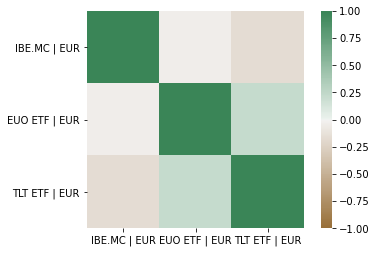

IBE.MC | EUR  EUO ETF | EUR  TLT ETF | EUR
IBE.MC | EUR       1.000000      -0.038617      -0.161574
EUO ETF | EUR     -0.038617       1.000000       0.221349
TLT ETF | EUR     -0.161574       0.221349       1.000000

In [5]:
log_change_df = invest_df.pct_change().apply(lambda x: np.log(1 + x)).dropna()

axis_corr = sns.heatmap(
    log_change_df.corr(),
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(50, 500, n=500),
    square=True
)

plt.show()

log_change_df.corr()

#### Step 1 : Portfolio Allocation - Optimize Portfolio Allocation
1. Optimize portfolio weights
2. Compare return and risk for individual stock vs portfolio
3. Calculate expected return for portfolio

In [6]:
print('-Buying Individual Stock will have below standard deviation & return')
print(f"{a1} - Return : {round(return_map[a1]*100, 2)}% | Standard Deviation : {round(log_change_df[a1].std(), 4)}")
print(f"{a2} - Return : {round(return_map[a2]*100, 2)}% | Standard Deviation : {round(log_change_df[a2].std(), 4)}")
print(f"{a3} - Return : {round(return_map[a3]*100, 2)}% | Standard Deviation : {round(log_change_df[a3].std(), 4)}")

w_agg, w_comt, w_vxx = optimize_portfolio_allocation(log_change_df, (a1, a2, a3))
weight_map = {a1: round(w_agg, 4), a2: round(w_comt, 4), a3: round(w_vxx, 4)}
port_std = portfolio_std(weight_map, log_change_df)
portfolio_return = return_map[a1] * w_agg + return_map[a2] * w_comt + return_map[a3] * w_vxx
print('')
print('-Buying the 3 asset portfolio will have below standard deviation & return')
print(f"Optimized Weight Allocation {weight_map}")
print(f'Portfolio Return : {round(portfolio_return*100, 2)}% | Standard Deviation : {round(port_std, 4)}')
print('')
print(f'Note: A return of {round(portfolio_return*100, 2)}% per annum is most likely not a realistic forecast')
print(f'      We will continue using this rate in below calculations')

-Buying Individual Stock will have below standard deviation & return
IBE.MC | EUR - Return : 21.09% | Standard Deviation : 0.0145
EUO ETF | EUR - Return : 6.35% | Standard Deviation : 0.0114
TLT ETF | EUR - Return : 9.67% | Standard Deviation : 0.0104

-Buying the 3 asset portfolio will have below standard deviation & return
Optimized Weight Allocation {'IBE.MC | EUR': 0.2829, 'EUO ETF | EUR': 0.2888, 'TLT ETF | EUR': 0.4282}
Portfolio Return : 11.94% | Standard Deviation : 0.0068

Note: A return of 11.94% per annum is most likely not a realistic forecast
      We will continue using this rate in below calculations


#### Step 2 : Performance Evaluation (Upon Retirement)
- initial investment: €82,500
- yearly investment(10 yrs): €30,000 inflated at 2%
- ignore breakdown into price and shares etc

In [7]:
total_saving = 165000
yearly_income = 215000
inflation_rate = 0.02
tax_rate = 0.2
invest_rate = 0.17
yearly_invest = round(yearly_income * (1 - tax_rate) * invest_rate, -4)
first_invest = total_saving / 2
invest_amounts = [-first_invest, -yearly_invest, -yearly_invest, -yearly_invest, -yearly_invest, -yearly_invest, -yearly_invest, -yearly_invest, -yearly_invest, -yearly_invest, -yearly_invest]
inflated_cashflows = [round(payment * (1 + inflation_rate)**idx, 2) for idx, payment in enumerate(invest_amounts)]
print(f'Yearly Investments - Income Tax {tax_rate * 100}% | Investment Rate {invest_rate*100}%(approx.)')
print(invest_amounts)
print(f'Yearly Investments - Inflation {round(inflation_rate * 100)}% | Income Tax {tax_rate * 100}% | Investment Rate {invest_rate*100}%(approx.)')
print(inflated_cashflows)
print('')

portfolio_FV_until_retirement = calc_future_value(portfolio_return, [-pay for pay in inflated_cashflows])
print(f'Future Value of Portfolio as of Retirement: {portfolio_FV_until_retirement} at {round(portfolio_return*100, 2)}% / year')

all_cashflows = inflated_cashflows.copy()
all_cashflows[-1] += portfolio_FV_until_retirement
discount_rate = 0.04
npv = calc_npv(discount_rate, all_cashflows)
print(f'Net Present Value of Investment(Valuation): {npv} with Discount Rate of {discount_rate * 100}% | should invest as NPV > 0')
print(f'Simpler Comparison: Portfolio Return {round(portfolio_return * 100, 2)}% > Discount Rate 4% | should invest')


Yearly Investments - Income Tax 20.0% | Investment Rate 17.0%(approx.)
[-82500.0, -30000.0, -30000.0, -30000.0, -30000.0, -30000.0, -30000.0, -30000.0, -30000.0, -30000.0, -30000.0]
Yearly Investments - Inflation 2% | Income Tax 20.0% | Investment Rate 17.0%(approx.)
[-82500.0, -30600.0, -31212.0, -31836.24, -32472.96, -33122.42, -33784.87, -34460.57, -35149.78, -35852.78, -36569.83]

Future Value of Portfolio as of Retirement: 830665.67 at 11.94% / year
Net Present Value of Investment(Valuation): 208636.67 with Discount Rate of 4.0% | should invest as NPV > 0
Simpler Comparison: Portfolio Return 11.94% > Discount Rate 4% | should invest


#### Step 3 : Performance Evaluation (After Retirement)
- client will withdraw 5% of the investment every year as an annuity for 15 years
- portfolio will continue to grow at expected return rate of the portfolio

In [8]:
annuities_aft_retire, portfolio_values_aft_retire = generate_annuity(portfolio_FV_until_retirement, portfolio_return, 15)

print(f'Portfolio Valuation for 15 Yrs After Retirement with 5% Withdrawals and Growth Rate {round(portfolio_return * 100, 2)}%')
print(portfolio_values_aft_retire)
print('Note: The rate of return is higer than the withdrawal rate, therefore portfolio valuation is still increasing even with withdrawals')

print('')
print(f'Annuities for 15 Yrs After Retirement with 5% Withdrawals')
print(annuities_aft_retire)

print('')
annuities_since_now = inflated_cashflows.copy() + annuities_aft_retire.copy()
npv_annuity = calc_npv(0.04, annuities_since_now)
print(f'All Cashflows from Now to Death(approx.)')
print(annuities_since_now)

print('')
print(f'Net Present Value of Annuities: {npv_annuity} with Discount Rate of {discount_rate * 100}% > 0 | should invest')

irr = nf.irr(annuities_since_now)
print('')
print(f'IRR of Annuities: {round(irr*100, 2)}% > Discount Rate of {discount_rate * 100}% | should invest')

Portfolio Valuation for 15 Yrs After Retirement with 5% Withdrawals and Growth Rate 11.94%
[883363.0, 939403.0, 998998.0, 1062374.0, 1129770.0, 1201442.0, 1277661.0, 1358715.0, 1444911.0, 1536575.0, 1634055.0, 1737719.0, 1847959.0, 1965193.0, 2089864.0]
Note: The rate of return is higer than the withdrawal rate, therefore portfolio valuation is still increasing even with withdrawals

Annuities for 15 Yrs After Retirement with 5% Withdrawals
[46493.0, 49442.0, 52579.0, 55914.0, 59462.0, 63234.0, 67245.0, 71511.0, 76048.0, 80872.0, 86003.0, 91459.0, 97261.0, 103431.0, 109993.0]

All Cashflows from Now to Death(approx.)
[-82500.0, -30600.0, -31212.0, -31836.24, -32472.96, -33122.42, -33784.87, -34460.57, -35149.78, -35852.78, -36569.83, 46493.0, 49442.0, 52579.0, 55914.0, 59462.0, 63234.0, 67245.0, 71511.0, 76048.0, 80872.0, 86003.0, 91459.0, 97261.0, 103431.0, 109993.0]

Net Present Value of Annuities: 179426.82 with Discount Rate of 4.0% > 0 | should invest

IRR of Annuities: 7.05% > Di